In [1]:
#!pip install -e ../Maccabee > /dev/null

In [2]:
from maccabee.data_analysis.data_metrics import AXES_AND_METRIC_NAMES
from maccabee.constants import Constants
import maccabee.data_sources as data_sources
from maccabee.parameters import build_default_parameters

from maccabee.data_generation import SampledDataGeneratingProcess, data_generating_method

# benchmarks
from maccabee.benchmarking import benchmark_model_using_concrete_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp_grid

# genmatch
from maccabee.examples.genmatch import GenmatchDataGeneratingProcess, build_genmatch_datasource, GENMATCH_SPECS
from maccabee.examples.genmatch import LogisticPropensityMatchingCausalModel

In [3]:
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
BASE_GENMATCH_DGP_PARAMS = {
  "OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0,
        "INTERACTION_THREE_WAY": 0,
  },
  "TREATMENT_EFFECT_HETEROGENEITY": 0,
  "ACTUAL_CONFOUNDER_ALIGNMENT": 0,
  "MIN_PROPENSITY_SCORE": 0.1,
  "MAX_PROPENSITY_SCORE": 0.9,
  "OUTCOME_NOISE_TAIL_THICKNESS": 1000,
  "SUBFUNCTION_CONSTANT_TAIL_THICKNESS": 1000,
  "TREATMENT_EFFECT_TAIL_THICKNESS": 1000
}

A_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
A_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.0,
    "INTERACTION_THREE_WAY": 0,
}
  
C_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
C_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.3,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.0,
    "INTERACTION_THREE_WAY": 0,
}

G_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
G_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.3,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.11,
    "INTERACTION_THREE_WAY": 0,
}

X_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
X_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.99,
    "POLY_CUBIC": 0.99,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.99,
    "INTERACTION_THREE_WAY": 0,
}

In [5]:
# Define axes and metrics to analyze
DATA_METRICS_SPEC = {
    Constants.AxisNames.OUTCOME_NONLINEARITY: [
        "Lin r2(X_obs, Y)",
        "Lin r2(X_true, Y)"
    ],
    Constants.AxisNames.TREATMENT_NONLINEARITY: [
        "Lin r2(X_obs, Treat Logit)",
        "Lin r2(X_true, Treat Logit)",
        "Log r2(X_obs, T)"
    ],
    Constants.AxisNames.PERCENT_TREATED: [
        "Percent(T==1)"
    ],
    Constants.AxisNames.BALANCE: [
        "Wass dist X_true: T=1<->T=0",
    ],
    Constants.AxisNames.ALIGNMENT: [
        "Lin r2(Y, Treat Logit)",
        "Lin r2(Y0, Treat Logit)"
    ],
    Constants.AxisNames.TE_HETEROGENEITY: [
        "std(TE)/std(Y)"
    ]
}

## Run MC Benchmarks

In [6]:
%%time

CONCRETE_IN_ANALYSIS_MODE = True

# Concrete Genmatch Benchmark
dgp = GenmatchDataGeneratingProcess(
    *GENMATCH_SPECS["G"],
    n_observations=1000,
    data_analysis_mode=CONCRETE_IN_ANALYSIS_MODE)

concrete_perf_agg, concrete_perf_raw, concrete_data_agg, concrete_data_raw = \
    benchmark_model_using_concrete_dgp(
        dgp=dgp,
        model_class=LogisticPropensityMatchingCausalModel,
        estimand=Constants.Model.ITE_ESTIMAND,
        num_sampling_runs_per_dgp=1,#20,
        num_samples_from_dgp=1,#112,
        data_analysis_mode=CONCRETE_IN_ANALYSIS_MODE,
        data_metrics_spec=DATA_METRICS_SPEC,
        n_jobs=7)

CPU times: user 43.4 ms, sys: 35.8 ms, total: 79.1 ms
Wall time: 358 ms


In [7]:
%%time

SAMPLED_IN_ANALYSIS_MODE = True

# Sampled Genmatch Benchmark
class ModifiedNoiseSampledDataGeneratingProcess(SampledDataGeneratingProcess):
    @data_generating_method(Constants.DGPVariables.OUTCOME_NOISE_NAME, [])
    def _generate_outcome_noise_samples(self, input_vars):
        return 0
    
dgp_params = build_default_parameters()
dgp_params.set_parameters(G_param_overrides)

sampled_perf_agg, sampled_perf_raw, sampled_data_agg, sampled_data_raw = \
    benchmark_model_using_sampled_dgp(
        dgp_params, build_genmatch_datasource(),
        dgp_kwargs={"data_analysis_mode": SAMPLED_IN_ANALYSIS_MODE},
        dgp_class=ModifiedNoiseSampledDataGeneratingProcess,
        model_class=LogisticPropensityMatchingCausalModel,
        estimand=Constants.Model.ITE_ESTIMAND,
        num_dgp_samples=1,#15,
        num_sampling_runs_per_dgp=1,
        num_samples_from_dgp=1,#35,
        data_analysis_mode=SAMPLED_IN_ANALYSIS_MODE,
        data_metrics_spec=DATA_METRICS_SPEC,
        n_jobs=7)

CPU times: user 222 ms, sys: 209 ms, total: 431 ms
Wall time: 1.41 s


## Data Metric Comparison

In [17]:
for axes, metrics in DATA_METRICS_SPEC.items():
    print(axes)
    for metric in metrics:
        print("\t", metric)
        
        key = f"{axes} {metric}"
        print("\t\tConcrete:", np.round(concrete_data_agg[key], 3))
        print("\t\tSampled:", np.round(sampled_data_agg[key], 3))

OUTCOME_NONLINEARITY
	 Lin r2(X_obs, Y)
		Concrete: 0.972
		Sampled: 0.963
	 Lin r2(X_true, Y)
		Concrete: 0.974
		Sampled: 0.966
TREATMENT_NONLINEARITY
	 Lin r2(X_obs, Treat Logit)
		Concrete: 0.774
		Sampled: 0.457
	 Lin r2(X_true, Treat Logit)
		Concrete: 1.0
		Sampled: 1.0
	 Log r2(X_obs, T)
		Concrete: 0.729
		Sampled: 0.614
PERCENT_TREATED
	 Percent(T==1)
		Concrete: 43.9
		Sampled: 48.3
BALANCE
	 Wass dist X_true: T=1<->T=0
		Concrete: 0.048
		Sampled: 0.041
ALIGNMENT
	 Lin r2(Y, Treat Logit)
		Concrete: 0.021
		Sampled: 0.359
	 Lin r2(Y0, Treat Logit)
		Concrete: 0.002
		Sampled: 0.321
TE_HETEROGENEITY
	 std(TE)/std(Y)
		Concrete: 0.985
		Sampled: 0.938


In [9]:
for name, vals in sampled_data_raw.items():
    if name.startswith("TREATMENT_NONLINEARITY"):
        print(name, vals)

TREATMENT_NONLINEARITY Log r2(X_obs, T) [0.614]
TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit) [0.457]
TREATMENT_NONLINEARITY Lin r2(X_true, Treat Logit) [1.0]


## Performance Comparison

Notes

At config A, 20-50 matches across runs. Wide distro. Should investigate the stability of the concrete distro when n=1000.

At config G, 20-50 has much lower bias in the sampled benchmark. The concrete function appears to be a worst case scenario given that very similar functions experience much lower typical bias. The distribution is right tailed and so it is possible that the concrete func chosen is just an (un)lucky sample from right tail.

I will test this by permuting the variable order in the exact same functional form.

### Concrete Performance

In [10]:
concrete_perf_agg

{'precision in estimation of heterogenous treatment effects': 3.799,
 'precision in estimation of heterogenous treatment effects (std)': 0.0}

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


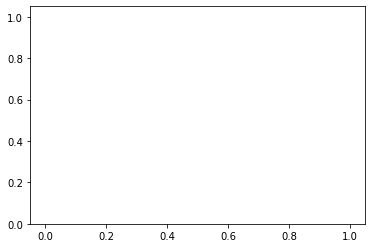

In [11]:
plt.hist(concrete_perf_raw["absolute mean bias %"], density=True)
plt.show()

### Sampled Performance

In [12]:
sampled_perf_agg

{'precision in estimation of heterogenous treatment effects': 1.011,
 'precision in estimation of heterogenous treatment effects (std)': 0.0}

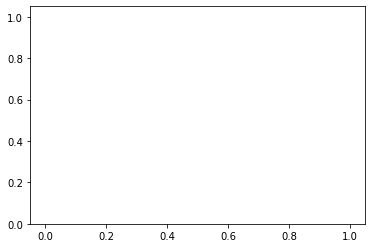

In [13]:
plt.hist(sampled_perf_raw["absolute mean bias %"], density=True)
plt.show()

### Exploratory Analysis

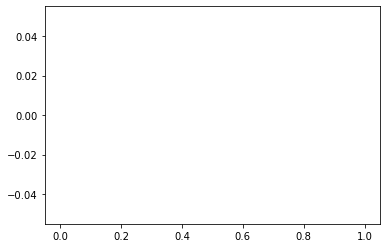

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [14]:
data = np.array(sampled_perf_raw["absolute mean bias %"])
clean_data = data[data < 20]
plt.hist(clean_data)
plt.show()
np.mean(clean_data)

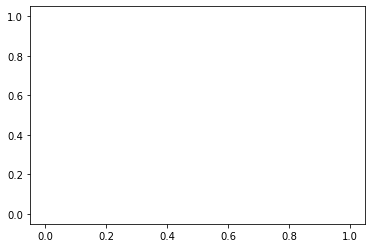

In [15]:
plt.scatter(
    np.array(sampled_data_raw["TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit)"])[data < 8],
    np.array(sampled_perf_raw["absolute mean bias %"])[data < 8])

ValueError: x and y must be the same size

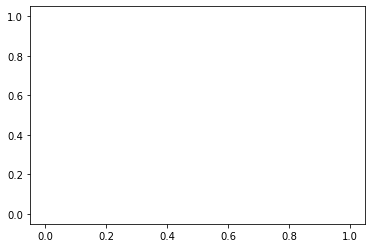

In [16]:
plt.scatter(
    np.array(sampled_data_raw["TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit)"])[data < 8],
    np.array(sampled_perf_raw["absolute mean bias %"])[data < 8],
    c="b")

plt.scatter(
    np.array(concrete_data_raw["TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit)"]),
    np.array(concrete_perf_raw["absolute mean bias %"]),
    c="r")